#Pytorch experiments


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from dataloader import DataLoader
from os.path import abspath
from entriesprocessor import EntriesProcessor
from trainer import Trainer
from model import Decoder, Encoder
import torch

EMBEDDING_SIZE = 10
HIDDEN_SIZE = 200
print(abspath('./'))
loader = DataLoader(10)
loader.parse_person_corpus(abspath('../Persons-1000/collection'))
loader.parse_rdf_corpus(abspath('../../corpus_for_pakhomov_2'))

C:\Users\Sdernal\Desktop\Jackals\TextNormalization\WithPytorch
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Абдулла Гюль.xml
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Адам Осмаев.xml
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Азим Исабеков.xml
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Александр Глухов.xml
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Александр Ломая.xml
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Александр Медведько.xml
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Анатолий Бибилов.xml
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Андрей Аршавин.xml
'None

In [3]:
print(len(loader.entries))
uniq_values = set([entry.value for entry in loader.entries])
print(len(uniq_values))

38953
14276


In [4]:
ep = EntriesProcessor(20,40)
# voc_size = 10
ep.process(loader.entries)
voc_size = ep.symbols_counter

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder(input_size=voc_size, hidden_size=HIDDEN_SIZE, embedding_size=EMBEDDING_SIZE).to(device)
decoder = Decoder(hidden_size=HIDDEN_SIZE, embedding_size=EMBEDDING_SIZE, output_size=voc_size, max_length=40).to(device)
trainer = Trainer(encoder,decoder,ep,max_input_length=40, max_output_length=20)

In [6]:
train_losses_all, test_losses_all = [], []

In [21]:
train_losses, test_losses = trainer.train(10, batch_size=256)
train_losses_all.extend(train_losses)
test_losses_all.extend(test_losses)


Epoch 1
	Train Loss: 0.365385 	 Time: 24s
	Test Loss: 0.377496 	 Time: 0s
Epoch 2
	Train Loss: 0.355810 	 Time: 24s
	Test Loss: 0.374940 	 Time: 0s
Epoch 3
	Train Loss: 0.358997 	 Time: 24s
	Test Loss: 0.377344 	 Time: 0s
Epoch 4
	Train Loss: 0.330463 	 Time: 24s
	Test Loss: 0.361399 	 Time: 0s
Epoch 5
	Train Loss: 0.340029 	 Time: 24s
	Test Loss: 0.366904 	 Time: 0s
Epoch 6
	Train Loss: 0.382265 	 Time: 24s
	Test Loss: 0.383492 	 Time: 0s
Epoch 7
	Train Loss: 0.326253 	 Time: 24s
	Test Loss: 0.373707 	 Time: 0s
Epoch 8
	Train Loss: 0.327076 	 Time: 24s
	Test Loss: 0.376704 	 Time: 0s
Epoch 9
	Train Loss: 0.327627 	 Time: 24s
	Test Loss: 0.565470 	 Time: 0s
Epoch 10
	Train Loss: 0.327444 	 Time: 24s
	Test Loss: 0.383103 	 Time: 0s


In [34]:
ethalons, results, inputs, matched, distances = trainer.test_model(False)

In [14]:
print(ethalons[:10])
print(results[:10])
print(inputs[:10])
print(matched[:10])
print(distances[:10])

['дэниэл фрид', 'мария чернова', 'эдриан коутс', 'эдриан коутс', 'эдриан коутс', 'эдриан коутс', 'фарит газизуллин', 'елена карпель', 'олег митволь', 'олег митволь']
['дэниэл чридом', 'марию чернов', 'эдриан коутс', 'эдриан коутс', 'эдриан коутса', 'эдриан коутса', 'фарит газизуллин', 'елена карпель', 'ледев', 'олег митволь']
['етаря сша дэниэлом фридом.\n\r\n\r"с ро', 'лужбы фас марию чернову утверждал', '\n\rим стал эдриан коутс, помогавш', 'исполнять эдриан коутс, возглавл', 'анка hsbc эдриана коутса. господин', 'вне.\n\r\n\rу эдриана коутса большой о', 'газпрома> фарита газизуллина. сохранил', 'разования елена карпель и зампред', 'олег митволь высадился', 'однадзора олег митволь должен бы']
[False, False, True, True, False, False, True, True, False, True]
[3, 2, 0, 0, 1, 1, 0, 0, 9, 0]


50 эпох

In [18]:
import numpy as np
print('Accuracy: ', np.mean(matched))
print('Mean distance: ', np.mean(distances))

Accuracy:  0.577613215608
Mean distance:  1.40871546568


60 эпох

In [35]:
import numpy as np
print('Accuracy: ', np.mean(matched))
print('Mean distance: ', np.mean(distances))

Accuracy:  0.540301908288
Mean distance:  1.55283395044


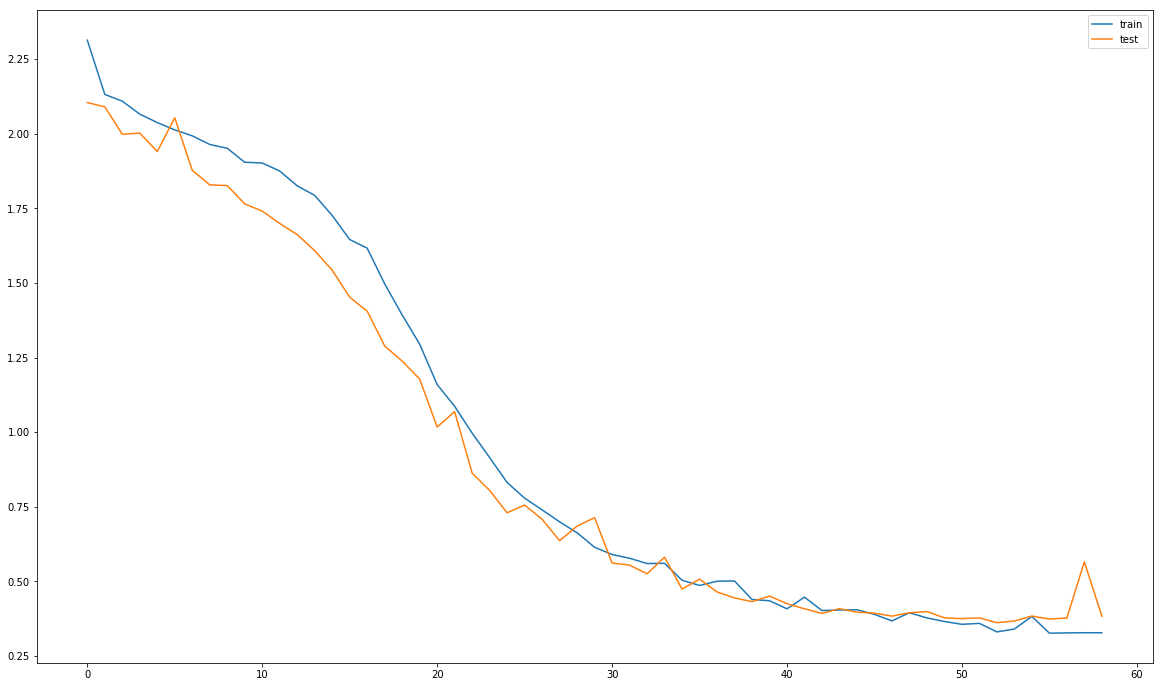

In [22]:
plt.figure(figsize=(20,12))
plt.plot(train_losses_all[1:], label='train')
plt.plot(test_losses_all[1:], label='test')
plt.legend()
plt.show()

In [27]:
import pandas as pd

data = {'ethalon' : ethalons, 'result' : results, 'input' : inputs, 'matched' : matched, 'distance' : distances}
df = pd.DataFrame(data=data, columns=['ethalon', 'result', 'input', 'matched', 'distance'])

In [29]:
df.head(20)

,ethalon,result,input,matched,distance
0,дэниэл фрид,дэниэл чридом,"етаря сша дэниэлом фридом.\n\r\n\r""с ро",False,3
1,мария чернова,марию чернов,лужбы фас марию чернову утверждал,False,2
2,эдриан коутс,эдриан коутс,"\n\rим стал эдриан коутс, помогавш",True,0
3,эдриан коутс,эдриан коутс,"исполнять эдриан коутс, возглавл",True,0
4,эдриан коутс,эдриан коутса,анка hsbc эдриана коутса. господин,False,1
5,эдриан коутс,эдриан коутса,вне.\n\r\n\rу эдриана коутса большой о,False,1
6,фарит газизуллин,фарит газизуллин,газпрома> фарита газизуллина. сохранил,True,0
7,елена карпель,елена карпель,разования елена карпель и зампред,True,0
8,олег митволь,ледев,олег митволь высадился,False,9
9,олег митволь,олег митволь,однадзора олег митволь должен бы,True,0


In [33]:
df.to_csv('results2.csv', encoding='utf-8')

In [ ]:
torch.save(encoder.state_dict(), 'encoder.pt')
torch.save(decoder.state_dict(),'decoder.pt')

In [ ]:
from entriesprocessor import EntriesProcessor
from trainer import Trainer
from model import Decoder, Encoder
import torch
from mockentries import generate_entries

EMBEDDING_SIZE = 10
HIDDEN_SIZE = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ep = EntriesProcessor(10,10)
entries = generate_entries(100000, 5)
ep.process(entries)
voc_size = ep.symbols_counter
encoder = Encoder(input_size=voc_size, hidden_size=HIDDEN_SIZE, embedding_size=EMBEDDING_SIZE).to(device)
decoder = Decoder(hidden_size=HIDDEN_SIZE, embedding_size=EMBEDDING_SIZE, output_size=voc_size, max_length=10).to(device)
trainer = Trainer(encoder,decoder,ep,max_input_length=10, max_output_length=10,
                  teacher_forcing_ratio=0.5, learning_rate = 0.05 )

In [ ]:
train_losses_all, test_losses_all = [],[]

In [ ]:
train_losses, test_losses = trainer.train(5,batch_size=256)
train_losses_all.extend(train_losses)
test_losses_all.extend(test_losses)